# Compare optimizer

In [13]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../')
import qtm.base, qtm.constant, qtm.onequbit, qtm.fubini_study
import importlib
importlib.reload(qtm.base)
importlib.reload(qtm.constant)
importlib.reload(qtm.onequbit)

<module 'qtm.onequbit' from '..\\qtm\\onequbit.py'>

In [3]:
# Theta, phi, lambdaz is the params of u3 gate
theta = np.random.uniform(0, np.pi)
phi = np.random.uniform(0, 2*np.pi)
lambdaz = 0

In [6]:
# Init quantum tomography 1 qubit
thetas = np.zeros((3,))
loss_values = []
qc = qiskit.QuantumCircuit(1, 1)
qc.u3(theta, phi, lambdaz, 0)
# Reduce loss value in 100 steps
thetas_sgd, loss_values_sgd = qtm.base.fit(
    qc, num_steps = 100, thetas = thetas, 
    create_circuit_func = qtm.onequbit.u_onequbit, 
    grad_func = qtm.base.grad_loss,
    loss_func = qtm.base.loss_basis,
    optimizer = qtm.base.sgd,
    verbose = 1,
    wire = 0
)


Step: 100%|██████████| 100/100 [00:28<00:00,  3.57it/s]


In [7]:
# Init quantum tomography 1 qubit
thetas = np.zeros((3,))
loss_values = []
qc = qiskit.QuantumCircuit(1, 1)
qc.u3(theta, phi, lambdaz, 0)
# Reduce loss value in 100 steps
thetas_adam, loss_values_adam = qtm.base.fit(
    qc, num_steps = 100, thetas = thetas, 
    create_circuit_func = qtm.onequbit.u_onequbit, 
    grad_func = qtm.base.grad_loss,
    loss_func = qtm.base.loss_basis,
    optimizer = qtm.base.adam,
    verbose = 1,
    wire = 0
)

print(thetas)


Step: 100%|██████████| 100/100 [00:27<00:00,  3.62it/s]

[0.60657567 1.23417524 0.23370523]


In [14]:
# Init quantum tomography 1 qubit
thetas = np.zeros((3,))
loss_values_qng = []
qc = qiskit.QuantumCircuit(1, 1)
qc.u3(theta, phi, lambdaz, 0)
# Reduce loss value in 100 steps

for i in range(0, 100):
    G = qtm.fubini_study.calculate_u3z_state(qc.copy(), thetas)
        
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.onequbit.u_onequbit,
        thetas, r = 1/2, s = np.pi/2, wire = 0)
    thetas = np.real(thetas - qtm.constant.learning_rate *
                        (np.linalg.pinv(G) @ grad_loss)) 
    qc_copy = qtm.onequbit.u_onequbit(qc.copy(), thetas, wire = 0)  
    loss = qtm.base.loss_basis(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values_qng.append(loss)



In [16]:
# Init quantum tomography 1 qubit
thetas = np.zeros((3,))
loss_values_qng_adam = []
qc = qiskit.QuantumCircuit(1, 1)
qc.u3(theta, phi, lambdaz, 0)
# Reduce loss value in 100 steps

for i in range(0, 100):
    G = qtm.fubini_study.calculate_u3z_state(qc.copy(), thetas)
        
    grad_loss = qtm.base.grad_loss(
        qc, 
        qtm.onequbit.u_onequbit,
        thetas, r = 1/2, s = np.pi/2, wire = 0)
    grad1 = np.real(np.linalg.inv(G) @ grad_loss)
    if i == 0:
        m, v = list(np.zeros(thetas.shape[0])), list(np.zeros(thetas.shape[0]))
    thetas = qtm.base.adam(thetas, m, v, i, grad1)  
    qc_copy = qtm.onequbit.u_onequbit(qc.copy(), thetas, wire = 0)  
    loss = qtm.base.loss_basis(qtm.base.measure(qc_copy, list(range(qc_copy.num_qubits))))
    loss_values_qng_adam.append(loss)

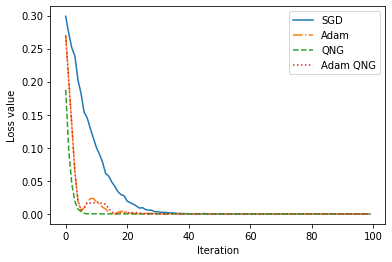

In [20]:
# Plot loss value in 100 steps
plt.plot(loss_values_sgd, label='SGD', linestyle = '-')
plt.plot(loss_values_adam, label='Adam', linestyle = '-.')
plt.plot(loss_values_qng, label='QNG', linestyle = '--')
plt.plot(loss_values_qng_adam, label='Adam QNG', linestyle = ':')
# plt.title('u3initstate_zbasis_onequbit')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.savefig('u3initstate_zbasis_onequbit1.png', format='png', dpi=600)
plt.show() 

In [8]:
np.savetxt("./compare/u3initstate_zbasis_onequbit/loss_values_sgd.csv", loss_values_sgd, delimiter=",")
np.savetxt("./compare/u3initstate_zbasis_onequbit/loss_values_adam.csv", loss_values_adam, delimiter=",")
np.savetxt("./compare/u3initstate_zbasis_onequbit/loss_values_qng.csv", loss_values_qng, delimiter=",")
np.savetxt("./compare/u3initstate_zbasis_onequbit/loss_values_qng_adam.csv", loss_values_qng_adam, delimiter=",")